In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt

### I/O

In [2]:
FIGURE_SAVEPATH = "../../../figures/"
TYPE1_ERROR_SAVEPATH = "../../../output/type1_errors/"
SAVELABEL = "null_dgps_asymptotic"

SAVE = True

### Formatting

In [3]:
method_cmap = {("Chiseling", 0): "#FF590D",
               ("Chiseling", 1): "#2032DA",
               "DataSplittingStrategy": "#FFBB00",
               "SimulDataSplittingStrategy": "#69C1B9",
               "OracleStrategy": "#000000",
               "OracleSimulStrategy": "#6A6A6A",
               "TTestStrategy": "#E70202"}

method_pretty_name_map = {("Chiseling", 0): "Chiseling (Single)",
                          ("Chiseling", 1): "Chiseling (Multiple)",
                          "DataSplittingStrategy": "Data Splitting",
                          "SimulDataSplittingStrategy": "Simul. Data Splitting",
                          "OracleStrategy": "Oracle",
                          "OracleSimulStrategy": "Simul. Oracle",
                          "TTestStrategy": r"$t$-test"}

legend_mapper = {"ipw": r"Error $\sim$ Exponential" + f"\nTransform = IPW",
                 "aipw": r"Error $\sim$ Exponential" + f"\nTransform = AIPW"}

LINEWIDTH = 4

MARKERSIZE = 40
LABEL_FONTSIZE = 24
TITLE_FONTSIZE = 24
LEGEND_FONTSIZE = 22
TICK_FONTSIZE = 19
HIDESPINES = True

alpha = 0.05

### Preprocessing

In [4]:
task_array_path = "../../task_arrays/null_dgps_asymptotic.tasks.tsv"
res_path = "../../../output/null_dgps_asymptotic/null_dgps_asymptotic.combined.tsv"

In [5]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [6]:
# Aggregate results
setting_identifiers = ["n", "d", "binary", "cov_type", "err_type",
                       "SPECIAL_TOKEN_NULLDGPS_TRANSFORM_TYPE", "test_thresh", "learner"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

### Settings

In [7]:
transform_type_space = ["ipw", "aipw"]

### Visualizations

Type I error

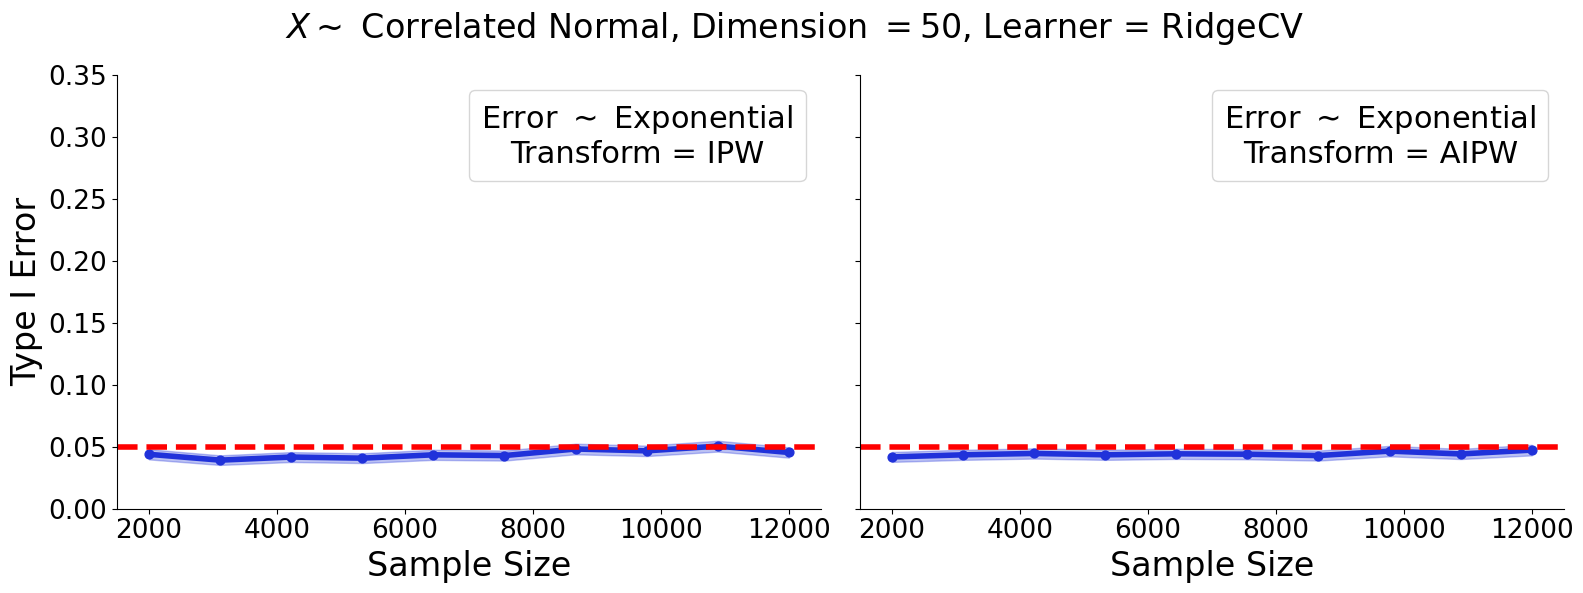

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16,6), sharex=True, sharey=True)

PLOT_SAVELABEL = "type1_error"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for transform_type in transform_type_space:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.SPECIAL_TOKEN_NULLDGPS_TRANSFORM_TYPE == transform_type]
    n_viz = sub_res_df.n.values
    t1e_viz = sub_res_df.rejected_mean.values
    t1e_se_viz = sub_res_df.rejected_se.values
    # Plot
    ax[AX0].plot(n_viz, t1e_viz, color=method_cmap[("Chiseling", 1)],
                 label=legend_mapper[transform_type], linewidth=LINEWIDTH)
    ax[AX0].scatter(n_viz, t1e_viz, color=method_cmap[("Chiseling", 1)], s=MARKERSIZE)
    ax[AX0].fill_between(n_viz,
                         t1e_viz - 2 * t1e_se_viz,
                         t1e_viz + 2 * t1e_se_viz,
                         color=method_cmap[("Chiseling", 1)],
                         alpha=0.3)
    # Special formatting for legend
    leg = ax[AX0].legend(handlelength=0, handletextpad=0, fancybox=True, fontsize=LEGEND_FONTSIZE)
    for item in leg.legend_handles:
        item.set_visible(False)
    for text_obj in leg.get_texts():
        text_obj.set_ha('center')
    # Add line for alpha
    ax[AX0].axhline(alpha, color="red", linestyle="--", linewidth=LINEWIDTH)
    # Set ylim
    ax[AX0].set_ylim(0,0.35)
    # Hide the right and top spines
    ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Titles
fig.suptitle(f"$X \\sim$ Correlated Normal, Dimension $= 50$, Learner = RidgeCV", fontsize=TITLE_FONTSIZE)

# y-labels
ax[0].set_ylabel("Type I Error", fontsize=LABEL_FONTSIZE)

# x-labels
ax[0].set_xlabel("Sample Size", fontsize=LABEL_FONTSIZE)
ax[1].set_xlabel("Sample Size", fontsize=LABEL_FONTSIZE)

# Tick fontsize
ax[0].tick_params(axis="both", labelsize=TICK_FONTSIZE)
ax[1].tick_params(axis="both", labelsize=TICK_FONTSIZE)

plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()